# Content based Filtering

In the content based filtering we generate two vectors, a user vector and an item vector whose dot product would predict a rating. Information about the users and items are provided to a neural network which then generates the user and item vector

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import estimator_html_repr

import joblib
from IPython.core.display import HTML

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, optimizers, callbacks

# Data

In [2]:
ratings = pd.read_csv('../input/book-recommendation-dataset/Ratings.csv')
print(ratings.shape)
ratings.head()

(1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [3]:
items = pd.read_csv('../input/book-recommendation-dataset/Books.csv')
print(items.shape)
items.head()

(271360, 8)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
items['Year-Of-Publication'] = items['Year-Of-Publication'].replace('DK Publishing Inc', np.nan).replace('Gallimard', np.nan).astype(float)

In [5]:
users = pd.read_csv('../input/book-recommendation-dataset/Users.csv')
print(users.shape)
users.head()

(278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
ratings_merged = ratings.merge(users, how='left').merge(items, how='left')
ratings_merged.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,"seattle, washington, usa",NaN,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,"h, new south wales, australia",16.0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...


In [7]:
ITEM_FEATURES = ['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']
USER_FEATURES = ['Location', 'Age']
TARGET = ['Book-Rating']

x_item = ratings_merged[ITEM_FEATURES]
x_user = ratings_merged[USER_FEATURES]
y = ratings_merged[TARGET]

x_item.shape, x_user.shape, y.shape

((1149780, 4), (1149780, 2), (1149780, 1))

# Preprocessing

In [8]:
def get_2d_to_1d(df):
    return df.reshape(-1)

impute_blanks = lambda: SimpleImputer(strategy='constant', fill_value='')
impute_median = lambda: SimpleImputer(strategy='median')

reshape = lambda: FunctionTransformer(get_2d_to_1d)

tfidf = lambda: TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
scale = lambda: StandardScaler()

preprocessor_items = ColumnTransformer([
    ('Book-Title', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Book-Title']),
    ('Book-Author', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Book-Author']),
    ('Year-Of-Publication', Pipeline([('impute', impute_median()), ('encoder', scale())]), ['Year-Of-Publication']),
    ('Publisher', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Publisher']),
])

preprocessor_users = ColumnTransformer([
    ('Location', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Location']),
    ('Age', Pipeline([('impute', impute_median()), ('encoder', scale())]), ['Age']),
])

ratings_scaler = MinMaxScaler()

x_item = preprocessor_items.fit_transform(x_item)
x_user = preprocessor_users.fit_transform(x_user)
y = ratings_scaler.fit_transform(y).reshape(-1)

x_item.shape, x_user.shape

((1149780, 5571), (1149780, 1695))

In [9]:
HTML(estimator_html_repr(preprocessor_items))

In [10]:
HTML(estimator_html_repr(preprocessor_users))

In [11]:
def sparse_array_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [12]:
x_item = sparse_array_to_sparse_tensor(x_item)
x_user = sparse_array_to_sparse_tensor(x_user)
y = y

2022-08-12 06:20:34.025549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 06:20:34.228667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 06:20:34.233035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 06:20:34.239260: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Networks

In [13]:
items_input = layers.Input(shape=(x_item.shape[1]))
items_ = layers.Dense(32, activation='relu')(items_input)
items_vector = layers.Dense(32, activation='relu')(items_)

users_input = layers.Input(shape=(x_user.shape[1]))
users_ = layers.Dense(32, activation='relu')(users_input)
users_vector = layers.Dense(32, activation='relu')(users_)

items_norm = tf.linalg.l2_normalize(items_vector, axis=1)
users_norm = tf.linalg.l2_normalize(users_vector, axis=1)

output = layers.Dot(axes=1)([items_norm, users_norm])

model = models.Model([items_input, users_input], output)

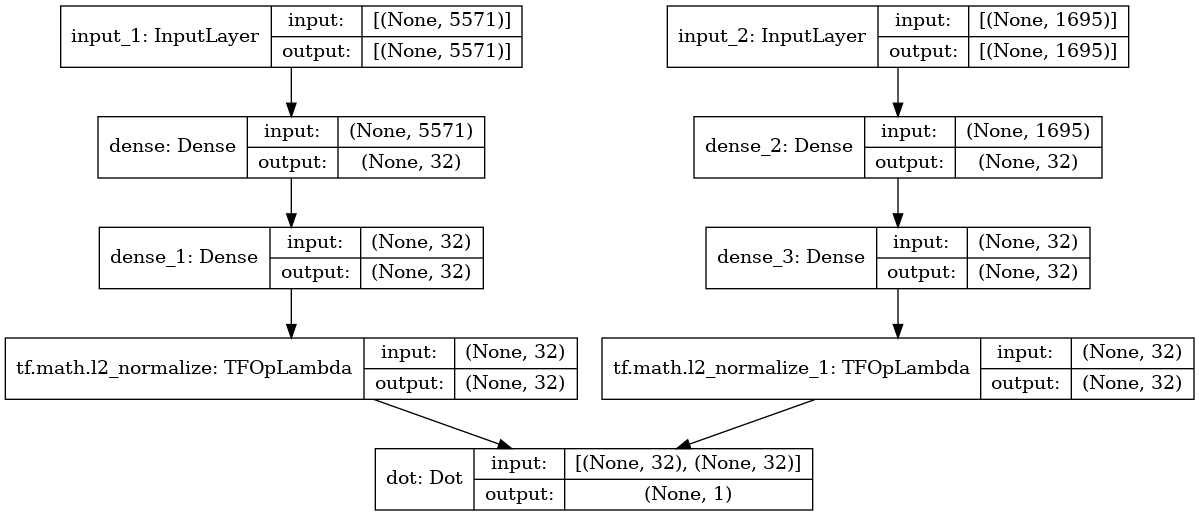

In [14]:
utils.plot_model(model, show_shapes=True, expand_nested=True)

In [15]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4))
model.summary()

es = callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)
rlp = callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1)

model.fit([x_item, x_user], y, callbacks=[es, rlp], epochs=250)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5571)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1695)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           178304      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           54272       input_2[0][0]                    
______________________________________________________________________________________________

2022-08-12 06:20:44.094819: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 890799840 exceeds 10% of free system memory.


Epoch 1/250


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense_2/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense_2/embedding_lookup_sparse/Reshape:0", shape=(None, 32), dtype=float32), dense_shap

35931/35931 [==============================] - 270s 7ms/step - loss: 0.1304
Epoch 2/250
35931/35931 [==============================] - 269s 7ms/step - loss: 0.1237
Epoch 3/250
35931/35931 [==============================] - 270s 7ms/step - loss: 0.1212
Epoch 4/250
35931/35931 [==============================] - 270s 7ms/step - loss: 0.1193
Epoch 5/250
35931/35931 [==============================] - 270s 7ms/step - loss: 0.1179
Epoch 6/250
35931/35931 [==============================] - 271s 7ms/step - loss: 0.1168
Epoch 7/250
35931/35931 [==============================] - 274s 7ms/step - loss: 0.1158
Epoch 8/250
35931/35931 [==============================] - 276s 7ms/step - loss: 0.1150
Epoch 9/250
35931/35931 [==============================] - 276s 8ms/step - loss: 0.1143
Epoch 10/250
35931/35931 [==============================] - 268s 7ms/step - loss: 0.1136
Epoch 11/250
35931/35931 [==============================] - 268s 7ms/step - loss: 0.1130
Epoch 12/250
35931/35931 [================

2022-08-12 12:48:57.454147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1124282 of 1149780


   17/35931 [..............................] - ETA: 6:11 - loss: 0.1093

2022-08-12 12:48:57.693897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35931/35931 [==============================] - 303s 8ms/step - loss: 0.1014

Epoch 00083: ReduceLROnPlateau reducing learning rate to 9.9999988758398e-14.
Epoch 84/250
35931/35931 [==============================] - 289s 8ms/step - loss: 0.1014
Epoch 85/250


2022-08-12 12:58:50.938644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1020420 of 1149780


   15/35931 [..............................] - ETA: 7:06 - loss: 0.1148

2022-08-12 12:58:52.508837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


35931/35931 [==============================] - 292s 8ms/step - loss: 0.1014
Restoring model weights from the end of the best epoch.

Epoch 00085: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.
Epoch 00085: early stopping


# Saving the models

In [16]:
model_items = models.Model(items_input, items_vector)
model_users = models.Model(users_input, users_vector)

joblib.dump(preprocessor_items, 'preprocessor_items.bin')
joblib.dump(preprocessor_users, 'preprocessor_users.bin')

model_items.save('model_items.h5')
model_users.save('model_users.h5')
model.save('model.h5')

In [17]:
input_items_vec = layers.Input(shape=(32))
norm_items = tf.linalg.l2_normalize(input_items_vec, axis=1)
input_users_vec = layers.Input(shape=(32))
norm_users = tf.linalg.l2_normalize(input_users_vec, axis=1)
output = layers.Dot(axes=1)([norm_items, norm_users])
dot_model = models.Model([input_items_vec, input_users_vec], output)
dot_model.save('dot_model.h5')

# Getting Recommendations

In [18]:
new_user = pd.DataFrame({'Location': ['new delhi, india'], 'Age': [25]})
new_user_preprocessed = preprocessor_users.transform(new_user)
new_user_vector = model_users.predict(new_user_preprocessed)
new_user_vector.shape

(1, 32)

In [19]:
all_item_preprocessed = preprocessor_items.transform(items[ITEM_FEATURES])
all_item_vector = model_items.predict(all_item_preprocessed)
all_item_vector.shape

(271360, 32)

In [20]:
new_user_vector = np.broadcast_to(new_user_vector, all_item_vector.shape)
preds = dot_model.predict([new_user_vector, all_item_vector])
items['preds'] = preds

**Recommendations**

In [21]:
items.sort_values('preds', ascending=False).head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,preds
110796,0877951705,Pastora,Joanna Barnes,1980.0,Arbor House Pub Co,http://images.amazon.com/images/P/0877951705.0...,http://images.amazon.com/images/P/0877951705.0...,http://images.amazon.com/images/P/0877951705.0...,0.979443
223933,0253212731,The Essential Husserl: Basic Writings in Trans...,Edmund Husserl,1999.0,Indiana University Press,http://images.amazon.com/images/P/0253212731.0...,http://images.amazon.com/images/P/0253212731.0...,http://images.amazon.com/images/P/0253212731.0...,0.974594
121774,0553283510,You Are a Millionaire (Choose Your Own Adventu...,Jay Leibold,1990.0,Skylark Books,http://images.amazon.com/images/P/0553283510.0...,http://images.amazon.com/images/P/0553283510.0...,http://images.amazon.com/images/P/0553283510.0...,0.970873
98158,848547175X,Cuentos de Ise,Ariwara Narihira,1998.0,Rama Publishing Company,http://images.amazon.com/images/P/848547175X.0...,http://images.amazon.com/images/P/848547175X.0...,http://images.amazon.com/images/P/848547175X.0...,0.970563
182912,3257233663,Amour fou.,Marek van der Jagt,2003.0,Diogenes,http://images.amazon.com/images/P/3257233663.0...,http://images.amazon.com/images/P/3257233663.0...,http://images.amazon.com/images/P/3257233663.0...,0.970333
